In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
cq_results = pd.read_csv("stat_by_day.csv",sep=';',decimal=',')
cq_results['Name'] = cq_results['DATE'].apply(lambda x: int(''.join(x.split('-'))))
cq_results.sort_values(by="Name",ascending=True, inplace=True)
cq_results.drop(columns=['DATE'],inplace=True)
# cq_results.head()

In [3]:
instance = pd.read_excel("instances.xlsx")

In [42]:
def objective_function(x):
    return x.travelCost + 100000*x.undeliveredCost + \
        1000*x.firstDeliveryCost + \
            30*x.underWorkCost + 20*x.overTimeCost                       

### Statistiques des instances

In [5]:
my_results = pd.read_csv("results_TIME.csv",sep=';')
my_results = my_results[my_results['TIME_LIMIT']==3600000]
my_results=  my_results.loc[my_results.groupby('Name')['satisfiedCost'].idxmax()]
df = pd.merge(left=my_results,right=cq_results,how='inner',on='Name')
df = pd.merge(left=df,right=instance,how='inner',on='Name')
instance_stats = pd.DataFrame(df['size'].value_counts())
instance_stats.reset_index(inplace=True)
instance_stats['Load']=  instance_stats.apply ( lambda x: f"{df[df['size']==x['index']]['demand'].min()}-{df[df['size']==x['index']]['demand'].max()}",axis=1)
instance_stats['#Order']=  instance_stats.apply ( lambda x: f"{df[df['size']==x['index']]['order'].min()}-{df[df['size']==x['index']]['order'].max()}",axis=1)
instance_stats['#Client']=  instance_stats.apply ( lambda x: f"{df[df['size']==x['index']]['client'].min()}-{df[df['size']==x['index']]['client'].max()}",axis=1)
instance_stats['#Driver']=  instance_stats.apply ( lambda x: f"{df[df['size']==x['index']]['driver'].min()}-{df[df['size']==x['index']]['driver'].max()}",axis=1)
instance_stats['#Depot']=  instance_stats.apply ( lambda x: f"{df[df['size']==x['index']]['depot'].min()}-{df[df['size']==x['index']]['depot'].max()}",axis=1)
instance_stats.sort_values(by=['index'],inplace=True,ascending=False)
instance_stats.set_index(['index'],inplace=True)
instance_stats.to_latex('instance_stats.tex')
print((instance_stats))

        size           Load   #Order #Client  #Driver #Depot
index                                                       
Small      8    226.5-937.5     7-14    4-11    13-35    1-3
Medium    14  1160.5-2971.0    43-98   40-89   76-137    6-8
Large     14  3078.5-3953.5  107-136  92-127  129-150    8-8


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_86211/3555464437.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  instance_stats.to_latex('instance_stats.tex')


## Comparer plusieurs runtime :1, 5, 10, 30, 60 min

In [60]:
my_results = pd.read_csv("results_TIME.csv",sep=';')
df = pd.merge(left=my_results,right=instance,how='inner',on='Name')
# my_results = my_results[my_results['undeliveredCost']<1]
df['served'] = df.apply(lambda x: 1 if x.undeliveredCost <0.5 else 0 ,axis=1)
df['Z'] = df.apply(lambda x: objective_function(x),axis=1)
df['completion'] = df.apply(lambda x: int(100*(x.satisfiedCost/x.demand)),axis=1)
df = df[['size','Name','served','satisfiedCost','undeliveredCost',
                         	'travelCost','firstDeliveryCost','maxfirstDelivery',
                            'underWorkCost','overTimeCost','driverUsed','TIME_LIMIT','runtime','Z','completion']]
df['TIME_LIMIT'] = df['TIME_LIMIT'].apply(lambda x: int((x/1000)/60))
df['runtime'] = df['runtime'].apply(lambda x: int((x/1000)/60))
# df  = df[df['served']==1]
numeric_columns = df.select_dtypes(include=[float, int]).columns
df[numeric_columns] = df[numeric_columns].round(2)
min_indices = df.groupby(by=['Name','TIME_LIMIT'])['satisfiedCost'].idxmax()
df1 = df.loc[min_indices]
# df1 = df.copy()
t1 = df1.groupby(by=['size','TIME_LIMIT']).agg({ 'served':'sum','undeliveredCost':'mean','completion':'mean'})
numeric_columns = t1.select_dtypes(include=[float, int]).columns
t1[numeric_columns] = t1[numeric_columns].round(2)

runtime = t1.pivot_table( index=['size'], columns=['TIME_LIMIT'], values=['completion']).stack(level=0)
runtime.sort_values(by=['size'],ascending=False, inplace=True)
runtime.rename(index={ 'completion':'\%Load','served':'#Instance'},inplace=True)
runtime.columns = pd.MultiIndex.from_product([['Runtime (min)'],runtime.columns])

s = runtime.style
s.caption='RMC delivered within different runtimes'
(s.format(subset='Runtime (min)',precision=2,thousands=","))#.format_index(escape="latex", axis=1))#.format_index(escape="latex", axis=0))

s.to_latex('runtime.tex',label='tab:runtime',multicol_align='c',position='htb',position_float='centering',hrules=True)

runtime
# df1
# my_results['Name'].value_counts()

Runtime (min)                                
TIME_LIMIT               1       5       10      30      60
size                                                       
Small  \%Load         100.0  100.00  100.00  100.00  100.00
Medium \%Load          99.0   99.29   99.29   99.43   99.57
Large  \%Load          99.0   99.21   99.36   99.43   99.50

## Results with all instances with t=60 minutes and local search using shift constraints

In [56]:
my_results = pd.read_csv("results_TIME.csv",sep=';')
my_results = my_results[my_results['TIME_LIMIT']==3600000]
my_results.sort_values(by="Name",ascending=True, inplace=True)
unsolved = list(dict.fromkeys(my_results[my_results['undeliveredCost']>0]['Name']))
print(len(unsolved),' ',  unsolved)
my_results = pd.merge(left=my_results,right=instance,how='inner',on='Name')

my_results['Z'] = my_results.apply(lambda x:objective_function(x),axis=1)
my_results['runtime'] = my_results['runtime'].apply(lambda x: (x/1000)/60)
my_results['UQ'] = my_results.apply(lambda x: x.demand-x.satisfiedCost,axis=1)

min_indices = my_results.groupby('Name')['Z'].idxmin()
# min_indices = my_results.groupby('Name')['travelCost'].idxmin()
best_result = my_results.loc[min_indices]

best_result = best_result[['size','Instance','Name','demand','depot',	'client','order','driver',
                           #'satisfiedCost',
         'travelCost','UQ','firstDeliveryCost','maxfirstDelivery',
         'underWorkCost','overTimeCost','Z']]
best_result.sort_values(by=["demand"],ascending=True, inplace=True)
best_result.rename(columns={'demand':'Demand','travelCost':'$TC$','firstDeliveryCost':'$FDD$',
           'maxfirstDelivery':'$mFDD$','underWorkCost':'$DUC$','overTimeCost':'$DOC$'
           ,'runtime':'Time' },inplace=True)
best_result.drop(['Name','depot','client','order','driver'],axis=1,inplace=True)

my_solved_results = my_results#[my_results['undeliveredCost']<1]

avg_result = my_solved_results.groupby(['Instance']).agg({
    'travelCost':'mean',
    'undeliveredCost':'mean',
    'firstDeliveryCost':'mean',
    # 'maxfirstDelivery':'mean',
     'underWorkCost':'mean',
     'overTimeCost':'mean'
    ,'Z':'mean',
    # 'driverUsed':'mean'
})
avg_result_size = my_solved_results.groupby(['size']).agg({
    'travelCost':'mean',
    'firstDeliveryCost':'mean',
    'maxfirstDelivery':'mean',
     'underWorkCost':'mean',
     'overTimeCost':'mean'
    ,'Z':'mean',
    # 'driverUsed':'mean'
})
avg_puo = my_results.groupby(['Instance']).agg({
    'undeliveredCost':'mean'
    # ,'runtime':'mean'
})
avg_puo_size = my_results.groupby(['size']).agg({
    'undeliveredCost':'mean'
    # ,'runtime':'mean'
})
stats = pd.merge(left=avg_result,right=best_result,on='Instance',how='inner')
# avg_puo
# stats = pd.merge(left=stats,right=avg_puo,on='Instance',how='inner')
numeric_columns = stats.select_dtypes(include=[float,int]).columns
stats[numeric_columns] = stats[numeric_columns].round(2)

col = stats.pop("Demand")
stats.insert(1, col.name, col)
col = stats.pop("undeliveredCost")
stats.insert(3, col.name, col)
stats.sort_values(['Demand'],inplace=True)

stats.rename(columns={'Z_x':'Z','driverUsed_x':'\#K','Z_y':'Z','driverUsed_y':'\#K',
                      'travelCost':'$TC$',   'firstDeliveryCost':'$FDD$',
           'maxfirstDelivery':'$mFDD$','underWorkCost':'$DUC$','overTimeCost':'$DOC$',
           'Z_x':'$Z$','undeliveredCost':'$UQ$'
           ,'runtime':'Time' },inplace=True)

stats.set_index(['size','Instance'],inplace=True)
# with_shift_stat = stats.groupby(by=['size']).mean()
# with_shift_stat
stats.columns = pd.MultiIndex.from_product([['Avg'],stats.columns,['(min)']])
s = stats.style
s.label='tab:all_instances'
s.caption='Results with all instances'
# stats.style.to_latex('df.tex',caption='Results with all instances',)
(s.format(subset='Avg',precision=1,thousands=","))#.format_index(escape="latex", axis=1))#.format_index(escape="latex", axis=0))
 
s.to_latex('df.tex',label='tab:all_instances',multicol_align='c',position='htb',position_float='centering',hrules=True)
stats

14   [20201006, 20201009, 20201013, 20201016, 20201030, 20201104, 20201106, 20201110, 20201113, 20201116, 20201120, 20201123, 20201124, 20201126]


Avg                                             \
                        Demand      $TC$  $UQ$    $FDD$    $DUC$    $DOC$   
                         (min)     (min) (min)    (min)    (min)    (min)   
size   Instance                                                             
Small  C_13_11_12_1      226.5   1243.55   0.0     0.00    10.82     0.00   
       C_13_5_8_1        267.0    745.10   0.0     0.00     0.00     0.00   
       C_18_6_11_2       333.5    753.26   0.0     0.00   145.89     0.00   
       C_15_4_7_2        375.0   1015.61   0.0     0.00   148.17   150.50   
       C_19_7_8_2        388.0   1747.15   0.0     0.00   349.81   159.01   
       C_29_10_14_3      613.5   3510.13   0.0    59.50   194.60   331.91   
       C_31_8_11_3       776.0   2314.77   0.0     0.00   804.26   640.70   
       C_35_9_10_3       937.5   4175.51   0.0     0.00   222.10   669.30   
Medium C_76_40_43_6     1160.5   6055.80   0.0    49.06  3286.37   990.05   
       C_104_42_47_8    1565.0   8107.08  12.0    53.33  3637.12   119.41   
       C_94_63_70_7     1746.5  13783.00   0.0   238.71   983.25  1554.56   
       C_116_67_78_8    1839.5  13456.76   0.0   132.69  1869.04   614.27   
       C_116_71_82_8    2060.0  11393.82   9.0   265.14  2714.84  1054.56   
       C_117_57_70_6    2327.5  14974.96   0.0   324.15  1005.51  1149.58   
       C_137_79_83_7    2425.0  17644.34   0.0   553.77  2320.40  1993.27   
       C_127_66_80_8    2512.5  14584.26   0.0   128.34  1599.98  1451.50   
       C_128_68_74_7    2595.0  18450.60   3.7   566.61  1317.55  2706.16   
       C_136_85_97_8    2673.0  16831.64   0.0   379.93  2702.42  2368.04   
       C_128_78_85_8    2685.5  15679.82  63.0   474.52  1399.64  2394.38   
       C_131_77_85_8    2893.5  16988.00   0.0   374.46  1557.88  1996.06   
       C_137_89_97_7    2939.5  21716.42   9.8   924.39   821.03  3494.41   
       C_133_84_98_7    2971.0  20435.46  46.1  1141.27   894.14  2127.81   
Large  C_132_98_109_8   3078.5  22994.64   0.0   465.48   496.54  3804.76   
       C_129_101_119_8  3229.0  17323.08  11.0   657.77  1577.59  2375.94   
       C_141_114_136_8  3350.5  19891.58  39.1  1255.78  1366.16  2251.91   
       C_140_114_132_8  3401.5  21917.58  23.8  1254.06   680.06  3389.86   
       C_143_101_123_8  3437.5  23477.22   0.0   677.71   955.52  4369.44   
       C_137_112_129_8  3471.0  22089.24   0.0   546.56   544.76  4187.29   
       C_142_114_129_8  3499.5  20678.20  35.7  1007.51  1119.73  4133.08   
       C_149_98_122_8   3513.0  19859.00  28.4  1141.73  2154.64  2649.89   
       C_139_98_108_8   3541.0  21060.52   0.0   966.16   684.86  3585.45   
       C_144_108_122_8  3670.5  23330.38   2.0  1123.42   536.22  3251.55   
       C_142_92_107_8   3684.5  23178.96   0.0   578.28   384.06  4260.42   
       C_138_114_136_8  3739.5  23614.64  11.7  1225.06   837.36  5668.56   
       C_150_127_136_8  3946.5  24940.30   0.0   949.50   775.52  5384.26   
       C_148_112_131_8  3953.5  24286.04  34.0  1247.84   656.97  3009.49   

                                                                             \
                               $Z$      $TC$    UQ    $FDD$ $mFDD$    $DUC$   
                             (min)     (min) (min)    (min)  (min)    (min)   
size   Instance                                                               
Small  C_13_11_12_1        1568.30   1243.55   0.0     0.00   0.00     0.00   
       C_13_5_8_1           745.10    745.10   0.0     0.00   0.00     0.00   
       C_18_6_11_2         5130.03    753.26   0.0     0.00   0.00   118.73   
       C_15_4_7_2          8470.90   1015.38   0.0     0.00   0.00   123.43   
       C_19_7_8_2         15421.56   1781.79   0.0     0.00   0.00   185.99   
       C_29_10_14_3       75488.14   3493.36   0.0    59.50  35.73   120.49   
       C_31_8_11_3        39256.77   2278.19   0.0     0.00   0.00   503.52   
       C_35_9_10_3        24224.67   4163.15   0.0     0.00   0.00   243.30  

### all results without shift constraints

In [62]:
my_results = pd.read_csv("results_shift.csv",sep=';')
my_results = my_results[my_results['NO_SHIFT_LIMIT']==1]
my_results.sort_values(by="Name",ascending=True, inplace=True)
unsolved = list(dict.fromkeys(my_results[my_results['undeliveredCost']>0]['Name']))
print(len(unsolved),' ',  unsolved)
my_results = pd.merge(left=my_results,right=instance,how='inner',on='Name')

my_results['Z'] = my_results.apply(lambda x:objective_function(x),axis=1)
my_results['runtime'] = my_results['runtime'].apply(lambda x: (x/1000)/60)
my_results['UQ'] = my_results.apply(lambda x: x.demand-x.satisfiedCost,axis=1)

min_indices = my_results.groupby('Name')['Z'].idxmin()
# min_indices = my_results.groupby('Name')['travelCost'].idxmin()
best_result = my_results.loc[min_indices]

best_result = best_result[['size','Instance','Name','demand','depot',	'client','order','driver',
                           #'satisfiedCost',
         'travelCost','UQ','firstDeliveryCost','maxfirstDelivery','Z']]
best_result.sort_values(by=["demand"],ascending=True, inplace=True)
best_result.rename(columns={'demand':'Demand','travelCost':'$TC$','firstDeliveryCost':'$FDD$',
           'maxfirstDelivery':'$mFDD$','underWorkCost':'$DUC$','overTimeCost':'$DOC$'
           ,'runtime':'Time' },inplace=True)
best_result.drop(['Name','depot','client','order','driver'],axis=1,inplace=True)

my_solved_results = my_results#[my_results['undeliveredCost']<1]

avg_result = my_solved_results.groupby(['Instance']).agg({
    'travelCost':'mean',
    'undeliveredCost':'mean',
    'firstDeliveryCost':'mean'
    # 'maxfirstDelivery':'mean',
    ,'Z':'mean',
    # 'driverUsed':'mean'
})
avg_result_size = my_solved_results.groupby(['size']).agg({
    'travelCost':'mean',
    'firstDeliveryCost':'mean',
    'maxfirstDelivery':'mean'
    ,'Z':'mean',
    # 'driverUsed':'mean'
})
avg_puo = my_results.groupby(['Instance']).agg({
    'undeliveredCost':'mean'
    # ,'runtime':'mean'
})
avg_puo_size = my_results.groupby(['size']).agg({
    'undeliveredCost':'mean'
    # ,'runtime':'mean'
})
stats = pd.merge(left=avg_result,right=best_result,on='Instance',how='inner')
# avg_puo
# stats = pd.merge(left=stats,right=avg_puo,on='Instance',how='inner')
numeric_columns = stats.select_dtypes(include=[float,int]).columns
stats[numeric_columns] = stats[numeric_columns].round(2)

col = stats.pop("Demand")
stats.insert(1, col.name, col)
col = stats.pop("undeliveredCost")
stats.insert(3, col.name, col)
stats.sort_values(['Demand'],inplace=True)

stats.rename(columns={'Z_x':'Z','driverUsed_x':'\#K','Z_y':'Z','driverUsed_y':'\#K',
                      'travelCost':'$TC$',   'firstDeliveryCost':'$FDD$',
           'maxfirstDelivery':'$mFDD$','underWorkCost':'$DUC$','overTimeCost':'$DOC$',
           'Z_x':'$Z$','undeliveredCost':'$UQ$'
           ,'runtime':'Time' },inplace=True)

stats.set_index(['size','Instance'],inplace=True)
# with_shift_stat = stats.groupby(by=['size']).mean()
# with_shift_stat
stats.columns = pd.MultiIndex.from_product([['Avg'],stats.columns,['(min)']])
s = stats.style
s.label='tab:all_instances'
s.caption='Results with all instances without shift constraints'
# stats.style.to_latex('df.tex',caption='Results with all instances',)
(s.format(subset='Avg',precision=1,thousands=","))#.format_index(escape="latex", axis=1))#.format_index(escape="latex", axis=0))
 
s.to_latex('no_shift_all.tex',label='tab:all_instances_no_shift',multicol_align='c',position='htb',position_float='centering',hrules=True)
stats

0   []


Avg                                               \
                        Demand      $TC$  $UQ$   $FDD$        $Z$      $TC$   
                         (min)     (min) (min)   (min)      (min)     (min)   
size   Instance                                                               
Small  C_13_11_12_1      226.5   1243.55   0.0    0.00    1243.55   1243.55   
       C_13_5_8_1        267.0    745.10   0.0    0.00     745.10    745.10   
       C_18_6_11_2       333.5    753.26   0.0    0.00     753.26    753.26   
       C_15_4_7_2        375.0   1013.68   0.0    0.00    1013.68   1013.11   
       C_19_7_8_2        388.0   1661.04   0.0    0.00    1661.04   1658.16   
       C_29_10_14_3      613.5   3235.52   0.0    0.00    3235.52   3198.61   
       C_31_8_11_3       776.0   2257.60   0.0    0.00    2257.60   2219.94   
       C_35_9_10_3       937.5   3834.00   0.0    0.00    3834.00   3808.83   
Medium C_76_40_43_6     1160.5   5262.38   0.0    0.00    5262.38   5187.25   
       C_104_42_47_8    1565.0   8278.02   0.0    0.00    8278.02   8209.60   
       C_94_63_70_7     1746.5  12730.30   0.0    0.00   12730.30  12551.90   
       C_116_67_78_8    1839.5  11884.38   0.0    0.00   11884.38  11641.40   
       C_116_71_82_8    2060.0  10750.88   0.0    0.00   10750.88  10697.10   
       C_117_57_70_6    2327.5  14547.02   0.0   25.83   40380.43  14746.80   
       C_137_79_83_7    2425.0  17822.38   0.0  120.02  137840.85  17982.50   
       C_127_66_80_8    2512.5  13622.25   0.0    0.00   13622.25  13565.00   
       C_128_68_74_7    2595.0  18641.65   0.0   74.10   92744.72  18554.80   
       C_136_85_97_8    2673.0  17336.28   0.0   51.81   69145.88  17610.50   
       C_128_78_85_8    2685.5  16781.18   0.0   55.51   72294.38  16658.50   
       C_131_77_85_8    2893.5  17789.08   0.0   22.00   39787.48  16923.50   
       C_137_89_97_7    2939.5  21831.72   0.0  214.21  236037.48  22630.70   
       C_133_84_98_7    2971.0  21031.10   0.0  474.04  495073.60  21179.30   
Large  C_132_98_109_8   3078.5  22272.30   0.0    7.17   29438.27  23294.50   
       C_129_101_119_8  3229.0  18473.82   0.0   41.64   60111.30  18595.20   
       C_141_114_136_8  3350.5  21237.42   0.0  136.69  157923.17  20762.90   
       C_140_114_132_8  3401.5  22518.40   0.0  173.97  196489.25  22537.00   
       C_143_101_123_8  3437.5  23807.45   0.0   39.11   62917.75  23249.30   
       C_137_112_129_8  3471.0  22457.50   0.0  120.98  143439.33  21878.20   
       C_142_114_129_8  3499.5  21574.42   0.0  362.84  384413.18  22591.10   
       C_149_98_122_8   3513.0  20918.70   0.0  150.58  171499.48  19503.40   
       C_139_98_108_8   3541.0  21548.10   0.0  271.51  293062.85  22008.30   
       C_144_108_122_8  3670.5  23603.95   0.0  169.22  192821.45  23200.90   
       C_142_92_107_8   3684.5  21279.50   0.0   83.81  105084.58  21244.20   
       C_138_114_136_8  3739.5  24385.28   0.0  109.80  134180.85  25218.00   
       C_150_127_136_8  3946.5  24434.18   0.0  391.04  415476.68  24732.20   
       C_148_112_131_8  3953.5  25846.18   0.0  566.83  592677.42  26245.80   

                                                        
                          UQ   $FDD$ $mFDD$          Z  
                       (min)   (min)  (min)      (min)  
size   Instance                                         
Small  C_13_11_12_1      0.0    0.00   0.00    1243.55  
       C_13_5_8_1        0.0    0.00   0.00     745.10  
       C_18_6_11_2       0.0    0.00   0.00     753.26  
       C_15_4_7_2        0.0    0.00   0.00    1013.11  
       C_19_7_8_2        0.0    0.00   0.00    1658.16  
       C_29_10_14_3      0.0    0.00   0.00    3198.61  
       C_31_8_11_3       0.0    0.00   0.00    2219.94  
       C_35_9_10_3       0.0    0.00   0.00    3808.83  
Medium C_76_40_43_6      0.0    0.00   0.00    5187.25  
       C_104_42_47_8     0.0    0.00   0.00    8209.60  
       C_94_63_70_7      0.0    0.00   0.00   12551.90  
       C_11

## Comparer les résultats avec et sans limitation de shift

In [46]:
my_results = pd.read_csv("results_shift.csv",sep=';')
# my_results.sort_values(by="Name",ascending=True, inplace=True)
# unsolved = list(dict.fromkeys(my_results[my_results['undeliveredCost']>0]['Name']))
my_results = my_results[my_results['NO_SHIFT_LIMIT']==1]
my_results = pd.merge(left=my_results,right=instance,how='inner',on='Name')
my_results['Z'] = my_results.apply(lambda x:objective_function(x),axis=1)
my_results['runtime'] = my_results['runtime'].apply(lambda x: (x/1000)/60)
my_results['PUO'] = my_results.apply(lambda x: x.demand-x.satisfiedCost,axis=1)
avg_no_shift = my_results[my_results['undeliveredCost']<1].groupby(by=['size']).agg( {'travelCost':'mean',
    'firstDeliveryCost':'mean',
    'maxfirstDelivery':'mean',
    # 'driverUsed':'mean'
    'Z':'mean',
    'driverUsed':'mean'})

avg_puo_no_shift = my_results.groupby(['size']).agg({
    'undeliveredCost':'mean'
})

A = pd.merge(left=avg_result_size.reset_index(),right=avg_puo_size.reset_index(),how='inner',on='size')
A = A[['size','travelCost','undeliveredCost','firstDeliveryCost',	'maxfirstDelivery']]
B = pd.merge(left=avg_no_shift.reset_index(),right=avg_puo_no_shift.reset_index(),how='inner',on='size')
B = B[['size','travelCost','undeliveredCost','firstDeliveryCost',	'maxfirstDelivery']]
df = pd.merge(left=A,right=B,how='inner',on='size')

df.sort_values(['travelCost_x'],ascending=True,inplace=True)

# df.drop(['runtime','Z_y','Z_x','driverUsed_x','underWorkCost','overTimeCost','driverUsed_y'],axis=1,inplace=True)
df.rename(columns={'Z_x':'Z','driverUsed_x':'\#K','Z_y':'$Z$','driverUsed_y':'\#K',
                      'travelCost_x':'$TC$',   'firstDeliveryCost_x':'$FDD$',
                      'travelCost_y':'$TC$',   'firstDeliveryCost_y':'$FDD$',
           'maxfirstDelivery_x':'$mFDD$',
           'maxfirstDelivery_y':'$mFDD$',
           'underWorkCost':'$DUC$','overTimeCost':'$DOC$','Z_x':'$Z$',
           'undeliveredCost_x':'$PUO$',
           'undeliveredCost_y':'$PUO$'
           },inplace=True)
df.set_index('size',inplace=True)
# numeric_columns = df.select_dtypes(include=[float, int]).columns
# df[numeric_columns] = df[numeric_columns].round(2)
df.columns = pd.MultiIndex.from_product([['D'],df.columns,['(min)']])
s = df.style
s.caption='Comparaison with and without shift and overtime constraints'
# stats.style.to_latex('df.tex',caption='Results with all instances',)
(s.format(subset='D',precision=2,thousands=","))#.format_index(escape="latex", axis=1))#.format_index(escape="latex", axis=0))
 
s.to_latex('shift.tex',label='tab:lift_shift_constraints',multicol_align='c',position='htb',position_float='centering',hrules=True)
df


D                                                        \
                $TC$      $PUO$       $FDD$     $mFDD$          $TC$ $PUO$   
               (min)      (min)       (min)      (min)         (min) (min)   
size                                                                         
Small    1938.134500   0.000000    7.437713   4.465838   1842.969375   0.0   
Medium  15007.282571  10.257143  400.454413  46.308916  14879.185536   0.0   
Large   22045.812857  13.264286  935.489729  56.930820  22454.085714   0.0   

                               
             $FDD$     $mFDD$  
             (min)      (min)  
size                           
Small     0.000000   0.000000  
Medium   74.108886  17.872861  
Large   187.512739  34.759869

## Compare LS VS noLS

In [68]:
my_results = pd.read_csv("results_LS.csv",sep=';')
my_results = pd.merge(left=my_results,right=instance,how='inner',on='Name')

my_results['Z'] = my_results.apply(lambda x:objective_function(x),axis=1)
my_results['runtime'] = my_results['runtime'].apply(lambda x: (x/1000)/60)
# my_results['PUO'] = my_results.apply(lambda x: x.demand - x.satisfiedCost,axis=1)
my_results.drop(['Date','Heure','Probleme','clientWaitingCost','MAX_OVERTIME','INTRA_ORDER_DELIVERY',
         'INTER_ORDER_DELIVERY','FIRST_DEL_MAX_ARRIVAL','Depot',
         'driverUsed','distanceCost',
         'NO_SHIFT_LIMIT',	'TIME_LIMIT','Z'],axis=1,inplace=True)
GRASP = my_results[my_results['LOCAL_SEARCH']==0]
avg_GRASP = GRASP[GRASP['undeliveredCost']<0.5].groupby(by=['size']).agg( {'travelCost':'mean',
    'firstDeliveryCost':'mean',
    'maxfirstDelivery':'mean',
    'underWorkCost':'mean',
    'overTimeCost':'mean',
    'runtime':'mean'
    })
avg_GRASP.loc[len(avg_GRASP)] = list(GRASP[GRASP['undeliveredCost']<0.5].agg( {'travelCost':'mean',
    'firstDeliveryCost':'mean',
    'maxfirstDelivery':'mean',
    'underWorkCost':'mean',
    'overTimeCost':'mean', 'runtime':'mean'}))
avg_GRASP.rename(index={3:'Avg'},inplace=True)
avg_GRASP_PUO = GRASP[GRASP['undeliveredCost']>0].groupby(by=['size']).agg({'undeliveredCost':'mean'})
avg_GRASP_PUO.loc[len(avg_GRASP_PUO)] = list(GRASP[GRASP['undeliveredCost']>0].agg({'undeliveredCost':'mean'}))
avg_GRASP_PUO.rename(index={2:'Avg'},inplace=True)
GRASP_result = pd.merge(avg_GRASP.reset_index(),avg_GRASP_PUO.reset_index(),how='left')
GRASP_result = GRASP_result[['size','travelCost','undeliveredCost','firstDeliveryCost',
                             	'underWorkCost','overTimeCost','runtime']]
GRASP_result.fillna(0,inplace=True)
GRASP_result.sort_values('undeliveredCost',ascending=True, inplace=True)

LS = my_results[my_results['LOCAL_SEARCH']==1]
avg_LS = LS[LS['undeliveredCost']<0.5].groupby(by=['size']).agg( {'travelCost':'mean',
    'firstDeliveryCost':'mean',
    'maxfirstDelivery':'mean',
    'underWorkCost':'mean',
    'overTimeCost':'mean', 'runtime':'mean'})
avg_LS.loc[len(avg_LS)] = LS[LS['undeliveredCost']<0.5].agg( {'travelCost':'mean',
    'firstDeliveryCost':'mean',
    'maxfirstDelivery':'mean',
    'underWorkCost':'mean',
    'overTimeCost':'mean', 'runtime':'mean'})
avg_LS.rename(index={3:'Avg'},inplace=True)
avg_LS_PUO = LS[LS['undeliveredCost']>0].groupby(by=['size']).agg({'undeliveredCost':'mean'})
avg_LS_PUO.loc[len(avg_LS_PUO)] = list(LS[LS['undeliveredCost']>0].agg({'undeliveredCost':'mean'}))
avg_LS_PUO.rename(index={2:'Avg'},inplace=True)
LS_result = pd.merge(avg_LS.reset_index(),avg_LS_PUO.reset_index(),how='left')
LS_result = LS_result[['size','travelCost','undeliveredCost','firstDeliveryCost',
                             	'underWorkCost','overTimeCost','runtime']]
LS_result.fillna(0,inplace=True)

df_compare = pd.merge(left=GRASP_result,right=LS_result,on='size',how='right')
df_compare.sort_values('undeliveredCost_x',ascending=True, inplace=True)

df_compare.set_index('size',inplace=True)

df_compare.drop(['undeliveredCost_x','undeliveredCost_y'],axis=1,inplace=True)

df_compare.rename(columns={'Z_x':'Z','driverUsed_x':'\#K','Z_y':'$Z$','driverUsed_y':'\#K',
                      'travelCost_x':'$TC$',   'firstDeliveryCost_x':'$FDD$',
                      'travelCost_y':'$TC$',   'firstDeliveryCost_y':'$FDD$',
           'maxfirstDelivery_x':'$mFDD$','maxfirstDelivery_y':'$mFDD$',
           'underWorkCost_x':'$DUC$', 'underWorkCost_y':'$DUC$',
           'overTimeCost_x':'$DOC$', 'overTimeCost_y':'$DOC$',
           'runtime_x':'Time', 'runtime_y':'Time',
           'Z_x':'$Z$',
           'undeliveredCost_x':'$PUO$', 'undeliveredCost_y':'$PUO$'
           },inplace=True)

t1 = GRASP.loc[GRASP.groupby('Name')['satisfiedCost'].idxmax()].groupby(['size']).agg({'satisfiedCost':'sum','demand':'sum'})
t1['Served'] = t1.apply(lambda x: 100*(x.satisfiedCost/x.demand),axis=1)
t2 = LS.loc[LS.groupby('Name')['satisfiedCost'].idxmax()].groupby(['size']).agg({'satisfiedCost':'sum','demand':'sum'})
t2['Served'] = t2.apply(lambda x: 100*(x.satisfiedCost/x.demand),axis=1)

df_compare['Served_G'] = t1['Served']
df_compare['Served_L'] = t2['Served']
df_compare['Load'] = t2['demand']
col = df_compare.pop("Served_G")
df_compare.insert(0, col.name, col)
col = df_compare.pop("Served_L")
df_compare.insert(7, col.name, col)
col = df_compare.pop("Load")
df_compare.insert(0, col.name, col)

df_compare.columns = pd.MultiIndex.from_product([['LS'],df_compare.columns,['(min)']])
s = df_compare.style
s.caption='Influence of the local search step on the GRASP algorithm'
# stats.style.to_latex('df.tex',caption='Results with all instances',)
(s.format(subset='LS',precision=2,thousands=","))#.format_index(escape="latex", axis=1))#.format_index(escape="latex", axis=0))

s.to_latex('LS_vs_noLS.tex',label='tab:grasp_ls_nols',multicol_align='c',position='htb',position_float='centering',hrules=True)
df_compare

LS                                                      \
           Load    Served_G          $TC$        $FDD$        $DUC$   
          (min)       (min)         (min)        (min)        (min)   
size                                                                  
Small    3917.0  100.000000   2012.845833     9.543645   204.595667   
Medium  32394.0   99.490646  13732.533810   526.291233  1742.760762   
Avg         NaN         NaN  10217.231091   414.519861   881.238455   
Large   49516.0   98.791300  22525.620000  1151.742900   695.984300   

                                                                      \
              $DOC$       Time          $TC$    Served_L       $FDD$   
              (min)      (min)         (min)       (min)       (min)   
size                                                                   
Small    294.141542  24.738515   1940.821667  100.000000    7.437712   
Medium  1689.865952  56.993604  14870.459259   99.644996  297.502293   
Avg     1506.473855  43.525291  13154.196216         NaN  350.549568   
Large   4030.948000  60.330098  22840.365217   99.686970  770.852217   

                                             
              $DUC$        $DOC$       Time  
              (min)        (min)      (min)  
size                                         
Small    227.296930   305.067846  60.530252  
Medium  1715.134370  1767.950481  60.388233  
Avg      895.267018  2011.000558  60.502003  
Large    629.826304  4076.423913  60.606081

## Comparer plusieurs valeurs de $\gamma^1$

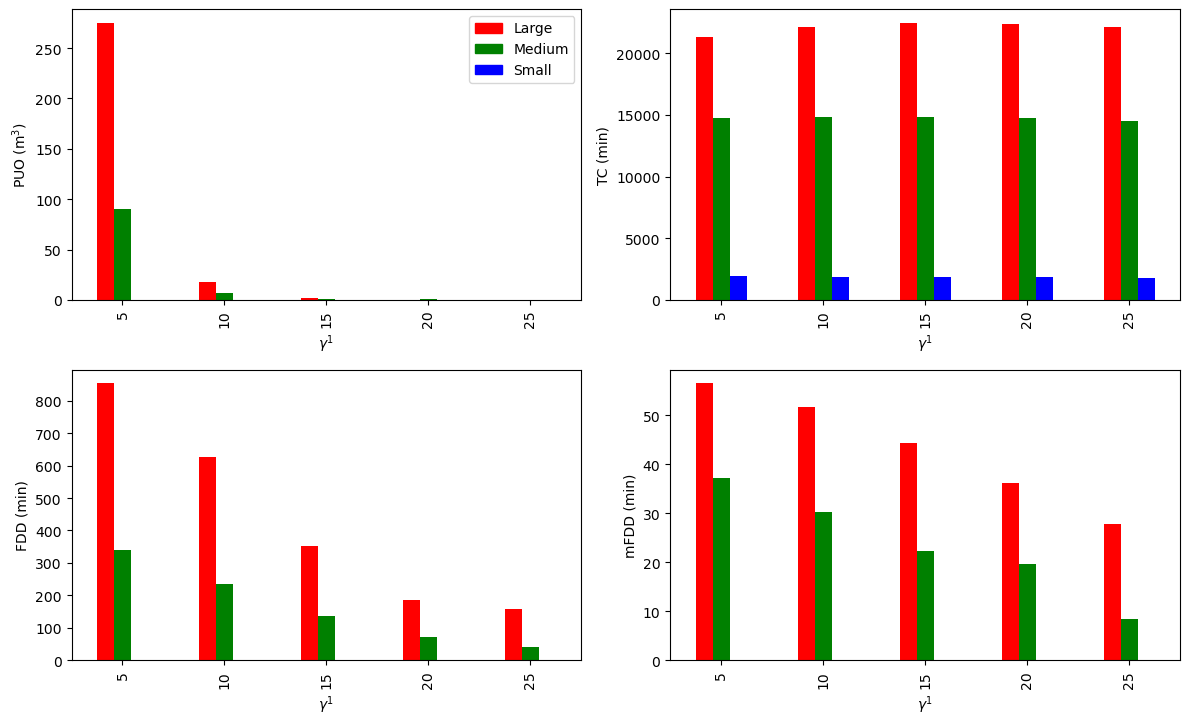

satisfiedCost  undeliveredCost    travelCost  \
size   INTRA_ORDER_DELIVERY                                                 
Large  5                       3261.726190       275.130952  21284.921429   
       10                      3519.404762        17.452381  22090.969048   
       15                      3535.059524         1.797619  22456.209524   
       20                      3536.857143         0.000000  22399.680952   
       25                      3536.857143         0.000000  22106.383333   
Medium 5                       2223.630952        90.226190  14763.167857   
       10                      2306.642857         7.214286  14857.409048   
       15                      2312.654762         1.202381  14783.970238   
       20                      2313.107143         0.750000  14756.094286   
       25                      2313.857143         0.000000  14533.575714   
Small  5                        489.625000         0.000000   1895.942083   
       10                       489.625000         0.000000   1886.544583   
       15                       489.625000         0.000000   1865.118750   
       20                       489.625000         0.000000   1845.434583   
       25                       489.625000         0.000000   1811.456667   

                             firstDeliveryCost  maxfirstDelivery  driverUsed  
size   INTRA_ORDER_DELIVERY                                                   
Large  5                            853.156667         56.458571  139.380952  
       10                           627.725952         51.660952  140.333333  
       15                           351.933810         44.215714  140.261905  
       20                           185.434762         36.200000  139.928571  
       25                           156.863810         27.735000  139.619048  
Medium 5                            341.157381         37.183810  115.690476  
       10                           235.940000         30.259286  116.000000  
       15                           135.951667         22.336667  115.857143  
       20                            73.241905         19.600238  116.190476  
       25                            40.140714          8.468095  114.761905  
Small  5                              0.000000          0.000000   20.458333  
       10                             0.000000          0.000000   20.875000  
       15                             0.000000          0.000000   20.750000  
       20                             0.000000          0.000000   20.583333  
       25                             0.000000          0.000000   19.291667

In [66]:
my_results = pd.read_csv("results_gamma.csv",sep=';')
my_results = my_results[['Name','satisfiedCost','undeliveredCost',
                         	'travelCost','firstDeliveryCost','maxfirstDelivery','INTRA_ORDER_DELIVERY','driverUsed']]
df = pd.merge(left=my_results,right=instance,how='inner',on='Name')
numeric_columns = df.select_dtypes(include=[float, int]).columns
df[numeric_columns] = df[numeric_columns].round(2)
df.sort_values(['demand'],ascending=True,inplace=True)

df.groupby(by=['INTRA_ORDER_DELIVERY','Name']).agg({'satisfiedCost':'mean',
                                                            'undeliveredCost':'mean',
                                                            'travelCost':'mean',
                                                            'firstDeliveryCost':'mean',
                                                            'maxfirstDelivery':'mean',
                                                            'driverUsed':'mean'
                                                            })
t2 = df.groupby(by=['size','INTRA_ORDER_DELIVERY']).agg({'satisfiedCost':'mean',
                                                            'undeliveredCost':'mean',
                                                            'travelCost':'mean',
                                                            'firstDeliveryCost':'mean',
                                                            'maxfirstDelivery':'mean',
                                                            'driverUsed':'mean'
                                                            })

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
colonnes = ['undeliveredCost','travelCost','firstDeliveryCost','maxfirstDelivery']
colonne1 = [r'PUO (m$^3$)','TC (min)','FDD (min)','mFDD (min)']
id = 0

red_patch = mpatches.Patch(color='red', label='Large')
green_patch = mpatches.Patch(color='green', label='Medium')
blue_patch = mpatches.Patch(color='blue', label='Small')
# handles.append(red_patch)
custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='blue', lw=4)]

for ax,col in zip(axes.flatten(),colonnes):
    grouped = t2.groupby(['INTRA_ORDER_DELIVERY','size'])[f"{col}"].sum().unstack()
    grouped.plot(kind='bar',color={'Large':'red','Medium':'green','Small':'blue'}, xlabel=None, legend=None,  ax=ax)
    # t2.xs(('Large')).plot(y =[f'{col}'],color='red',xlabel=None, legend=None, ax=ax,kind='bar',)
    # t2.xs(('Medium')).plot(y =[f'{col}'],color='green',xlabel=None, legend=None, ax=ax ,kind='bar' )
    # t2.xs(('Small')).plot(y =[f'{col}'],color='blue', legend=None,  ax=ax ,kind='bar' )
    
    ax.set_ylabel(f"{colonne1[id]}")
    ax.set_xlabel(f'$\gamma^1$')
    if id==0:
        ax.legend(handles=[red_patch,green_patch, blue_patch])        
    id = id + 1
    # break
handles, labels = ax.get_legend_handles_labels()

# fig.text(0.5, 0.05, f'$\lambda_1$', ha='center', fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("gamma1.pdf", format="pdf")
plt.show()
t2


### Influence des objectifs les uns sur les autres

coefficient de Pearson = 0.9976851192969451


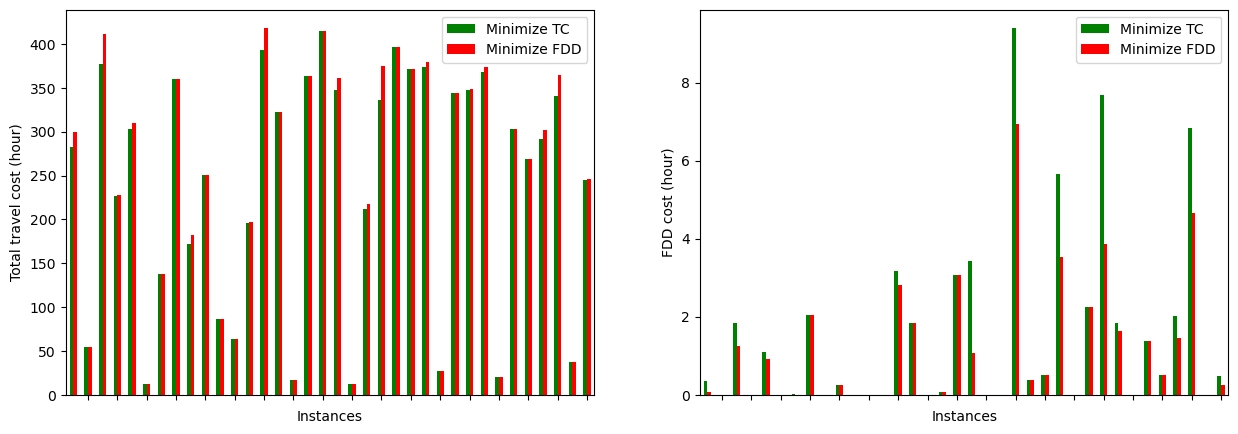

In [95]:
my_results = pd.read_csv("results_gamma.csv",sep=';')
my_results = my_results[my_results['INTRA_ORDER_DELIVERY']==20]
my_results['travelCost'] = my_results['travelCost'].apply(lambda x: x/60)
my_results['firstDeliveryCost'] = my_results['firstDeliveryCost'].apply(lambda x: x/60)
my_results = my_results[my_results['undeliveredCost']<0.5]
travel = my_results.loc[my_results.groupby(by=['Name'])['travelCost'].idxmin()]
first = my_results.loc[my_results.groupby(by=['Name'])['firstDeliveryCost'].idxmin()]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
travel = travel[['Name','travelCost','firstDeliveryCost']]
first = first[['Name','travelCost','firstDeliveryCost']]
travel.rename(columns={'travelCost':'TC1','firstDeliveryCost':'FDD1'},inplace=True)
first.rename(columns={'travelCost':'TC2','firstDeliveryCost':'FDD2'},inplace=True)
df = pd.merge(left=travel,right=first,on='Name')
df.plot(x='Name',y=['TC1','TC2'],kind='bar',xlabel='',color={'TC1':'green','TC2':'red'}, ax=axes[0])
axes[0].set_xlabel(xlabel='Instances')
axes[0].set_ylabel(ylabel='Total travel cost (hour)')
axes[0].legend(['Minimize TC','Minimize FDD'])
axes[0].set_xticks(ticks=np.arange(1,36,2),labels='')
# fig.savefig('travel.pdf')
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
df.plot(x='Name',y=['FDD1','FDD2'],kind='bar',xlabel='',color={'FDD1':'green','FDD2':'red'}, ax=axes[1])
axes[1].set_xlabel(xlabel='Instances')
axes[1].set_ylabel(ylabel='FDD cost (hour)')
axes[1].legend(['Minimize TC','Minimize FDD'])
axes[1].set_xticks(ticks=np.arange(1,36,2),labels='')
fig.savefig('Trav_FDD.pdf')

x = df['TC2']
y = df['TC1'] 
coeff_pearson,_ = pearsonr(x,y)
print("coefficient de Pearson = {}".format(coeff_pearson))


In [89]:
my_results = pd.read_csv("results_gamma.csv",sep=';')
my_results['travelCost'] = my_results['travelCost'].apply(lambda x: x/60)
my_results['firstDeliveryCost'] = my_results['firstDeliveryCost'].apply(lambda x: x/60)
my_results = my_results[my_results['undeliveredCost']<0.5]
names = [20201010,20201017,20201021,20201026,20201031,20201107,20201109,2020112]
distance = my_results.loc[my_results.groupby(by=['Name','INTRA_ORDER_DELIVERY'])['distanceCost'].idxmin()]
distance = distance[['Name','INTRA_ORDER_DELIVERY','distanceCost']]
travel = pd.read_csv("travel.csv",sep=';')
distance = distance[distance['Name'].isin(names)]
df=distance.groupby(['Name','INTRA_ORDER_DELIVERY'],axis=0).mean().unstack()
df = pd.merge(left=travel,right=df,on='Name')

df = pd.merge(left=df,right=instance[['Name','Instance']],on='Name')
df.drop(['Unnamed: 0','Name'],axis=1,inplace=True)
df.set_index('Instance',inplace=True)
df.columns = pd.MultiIndex.from_product([[f'$\gamma^1$'],df.columns,['(min)']])

s = df.style
s.caption='Comparaison with partner operations'

(s.format(subset=f'$\gamma^1$',precision=1,thousands=","))#.format_index(escape="latex", axis=1))#.format_index(escape="latex", axis=0))
 
s.to_latex('real_comp.tex',label='tab:comp_unibeton',multicol_align='c',position='htb',position_float='centering',hrules=True)

df
# distance


/var/folders/ym/09bxjqq91yn1yjvfy33yk4nw0000gn/T/ipykernel_86211/3804212507.py:11: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df = pd.merge(left=travel,right=df,on='Name')


$\gamma^1$                                                   \
                  Demand           D (distanceCost, 5) (distanceCost, 10)   
                   (min)       (min)             (min)              (min)   
Instance                                                                    
C_13_5_8_1         267.0    543.0532           523.463            523.463   
C_76_40_43_6      1160.5   5244.6754          5101.160           4706.050   
C_116_67_78_8     1839.5  11664.7716         11895.800          11035.300   
C_15_4_7_2         375.0    789.2826           702.313            702.885   
C_18_6_11_2        333.5    555.1320           491.738            471.468   
C_94_63_70_7      1746.5  12011.2220         12957.100          11965.500   

                                                                        
              (distanceCost, 15) (distanceCost, 20) (distanceCost, 25)  
                           (min)              (min)              (min)  
Instance                                                                
C_13_5_8_1               523.463            523.463            523.463  
C_76_40_43_6            4673.260           4645.650           4732.410  
C_116_67_78_8          11064.200          10928.900          10823.400  
C_15_4_7_2               702.313            703.456            702.314  
C_18_6_11_2              471.468            471.468            471.468  
C_94_63_70_7           11915.600          11657.100          11475.700